Тестовое задание yandex


Шаг 1: найдем все битые диалоги и запишем их номера в новую таблицу broken_dialogs

считаем битыми диалоги, у которых:
1) говорит робот или сотрудник, но номер события не равен 2
2) говорит клиент, но номер события не равен 1
3) в одном диалоге, у которого event = 0 (диалог начат)
    +   есть более одной записи
    + временная метка не является минимальной по диалогу
    + значение ссылки предыдущего поста не нулевое
4) в одном диалоге, у которого event = 3 (диалог закончен)
    + есть более одной записи
    + временная метка не является максимальной по диалогу
5) в одном диалоге пристуствуют неуникальные номера клиента


In [ ]:
-- найдем и запишем битые диалоги в новую таблицу
create table if not exists broken_dialogs as 
select DialogID

from ( 
    -- выявляем диалоги, у которых события по логике не совпадают с OfficerID

    select DialogID from DialogsPosts
    where 
        (OfficerID <> 0 and EventType <>2)  -- говорит робот или сотрудник, но событие - не сообщение поддержки
        or (OfficerID=0 and EventType <> 1) -- говорит клиент, но событие этому не соответствует 
    

union 

    -- выявляем уникальные номера битых диалогов, у которых:
    -- event = 0 (диалог начат), но временная метка не минимальная по диалогу или существует номер последнего поста (этого не должно быть)
    -- или event =3 (диалог закончен), но временная метка не максимальная по диалогу
    select distinct DialogID 
    from 
    (select * from DialogsPosts where EventType in (0,3)) as sed -- начало/конец диалога
    left outer join 

    (select DialogID, min(TimeStamp) as min_ts, max(TimeStamp) as max_ts
    from DialogsPosts
    group by DialogID) as mints

    using(DialogID)

    where EventType=0 and
        (TimeStamp <> min_ts or LastPostID is not null)
        or
        EventType =3 and TimeStamp <>max_ts

union

    -- выбираем битые диалоги, у которых имя клиента не уникально 
    -- (среднее значение номера не равно любому из значений)
    select distinct DialogID from 
    DialogsPosts inner join (
        select DialogID, avg(ClientID) as true_client_id
        from DialogsPosts
        group by DialogID) as true_cid using(DialogID)

    where  true_client_id <> ClientID 

union

    -- битые диалоги, которые имеют больше одного начал
    select DialogID
    from(

        select DialogID, EventType
        from DialogsPosts
        where EventType = 0) as only_start_dia

    group by DialogID
    having count(EventType) >1

union 

    -- диалоги, которые имеют больше одного завершений 
    select DialogID
    from(

        select DialogID, EventType
        from DialogsPosts
        where EventType =3) as only_start_dia

    group by DialogID
    having count(EventType) >1
    ) as temp_query
;



Битые диалоги под номерами 1,3, 7, 8, 12

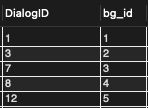

Для каждого «чистого» (т. е. «небитого») диалога рассчитать время решения проблемы клиента и отранжировать диалоги по полученному значению

In [ ]:

select DialogID, dec_time_in_minutes from 
	
    -- вложенный запрос для определения времени, потраченного на весь диалог
    (select DialogID,
	 -- min(TimeStamp)as min_ts, max(TimeStamp) as max_ts, -- строка для проверки правильности расчетов
	TIMESTAMPDIFF(minute, min(TimeStamp),max(TimeStamp)) as dec_time_in_minutes -- считаем разницу между началом
																				-- и концом диалога в минутах
	from DialogsPosts
	group by DialogID

	having DialogID not in 					-- отбираем только чистые диалоги (не битые)
	(select DialogID from broken_dialogs) 
	) as time_diff

-- пересекаем полученные диалоги , отбирая только те, ЧТО РЕШЕНЫ
inner join (select DialogID from DialogsPosts where EventType =3) as only_solved
using(DialogID) 
order by dec_time_in_minutes    -- сортируем по времени решения

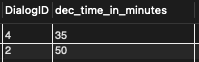

Отдельно вытащим информацию по диалогам:

+ кто решал (робот/человек)
+ сколько человек решало (один/много)
+ какой диалог еще в процессе решения (не завершен)

In [ ]:
select DialogID, who_solve,  
ifnull(is_solved,0) as is_solved, -- заполняем строку нулями, если при объединении появляются пустые значения
ifnull(is_solved_one_person,0) as is_solved_one_person,
ifnull(is_solved_more_one_person,0) as is_solved_many_person
from	
	(-- диалоги, которые решались с участием людей
		select distinct DialogID, 
		"human" as  who_solve
					from DialogsPosts
					where OfficerID>0
					
		union 

		-- диалоги, что решались только роботом
		select distinct DialogId,
		"robot" as  who_solve
		from DialogsPosts

		where DialogId not in (
			select DialogID
			from DialogsPosts
			where OfficerID>0) 
		) as who_solve_table
        
left outer join 
-- те диалоги, что решены
	(select DialogID,
	1 as is_solved
	from DialogsPosts
	where EventType =3 ) as only_solved
using(DialogID) 

left outer join 
-- разделям на диалоги, которые решались/решаются одним человеком или несколькими людьми
	(select DialogID, 
		if(num_persons=1, 1,0) as is_solved_one_person,
		if(num_persons>1, 1,0) as is_solved_more_one_person
		from(
			select DialogID, count(distinct(OfficerID)) as num_persons
			from (
				select DialogID, OfficerID
				from DialogsPosts
				where OfficerID>0
				) as solved_with_human
			group by DialogID
			) as temp
	) as how_many_people
using(DialogID)        


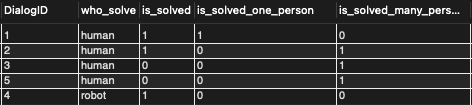

Запишем эту информацию в отдельную таблицу classified_dialogs и из нее организуем запрос по условию:

Разметить диалоги в следующие классы: «решены роботом», «решены с привлечением одного специалиста», «решены с привлечением более чем одного специалиста», «не решены или находятся в процессе решения».

In [ ]:
select * from classified_dialogs;

select DialogID, 
if(is_solved=1 and who_solve="robot", 1,0) as Реш_роботом,
if(is_solved=1 and is_solved_one_person=1, 1,0) as реш_с_привлечением_1_специалиста,
if(is_solved=1 and is_solved_many_person=1, 1,0) as решены_с_привлечением_более_чем_1_специалиста,
if(is_solved=0, 1,0) as не_реш_или_находятся_в_процессе_решения
from classified_dialogs

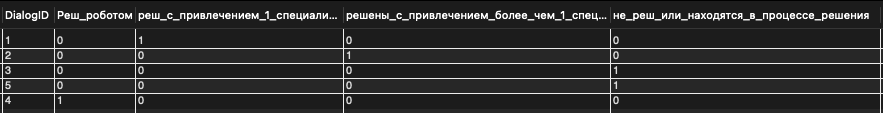